# Dynamic power and quantization

_23 July 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

These are the first plots after I implemented dynamic quantization range for the digital scheme, which shouldn't affect dynamic power scheme, but this did involve some refactoring of the dynamic power code to reuse the exponential moving average framework for dynamic quantization in the digital scheme.

I later updated these to include low-noise runs ($\sigma_\mathrm{n}^2 \in \{0.0001, 0.001, 0.01\}$), and then even lower noise ($\sigma_\mathrm{n}^2 \in \{10^{-9}, 10^{-6}\}$). As a consequence, some of these plots now have a lot of lines on them, and give the general picture but aren't necessarily the most readable.

Note: These plots increased the dataset size to 20000, since we're only going up to 20 clients.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from plots_utils import plot_averaged_training_charts, plot_comparison, show_timestamp_info

# Dynamic power, $n = 5$

On commit [`ca68e08`](https://github.com/czlee/jadeite/commit/ca68e084260bd2bbcb6ce190de26dd75583b8740).

In [2]:
results_dir = [Path("results/20210722-dynpower-2/"), Path("results/20210723-lownoise-dynpower"), Path("results/20210724-epsilon-dynpower")]
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Jul 2021, 08:52:50** | 22 Jul 2021, 09:04:22 | 11 min 31 s |
| last to finish | 24 Jul 2021, 23:28:44 | **25 Jul 2021, 00:01:37** | 32 min 53 s |
| shortest | 24 Jul 2021, 14:58:03 | 24 Jul 2021, 15:07:51 | **9 min 47 s** |
| longest | 23 Jul 2021, 07:57:00 | 23 Jul 2021, 08:42:28 | **45 min 28 s** |


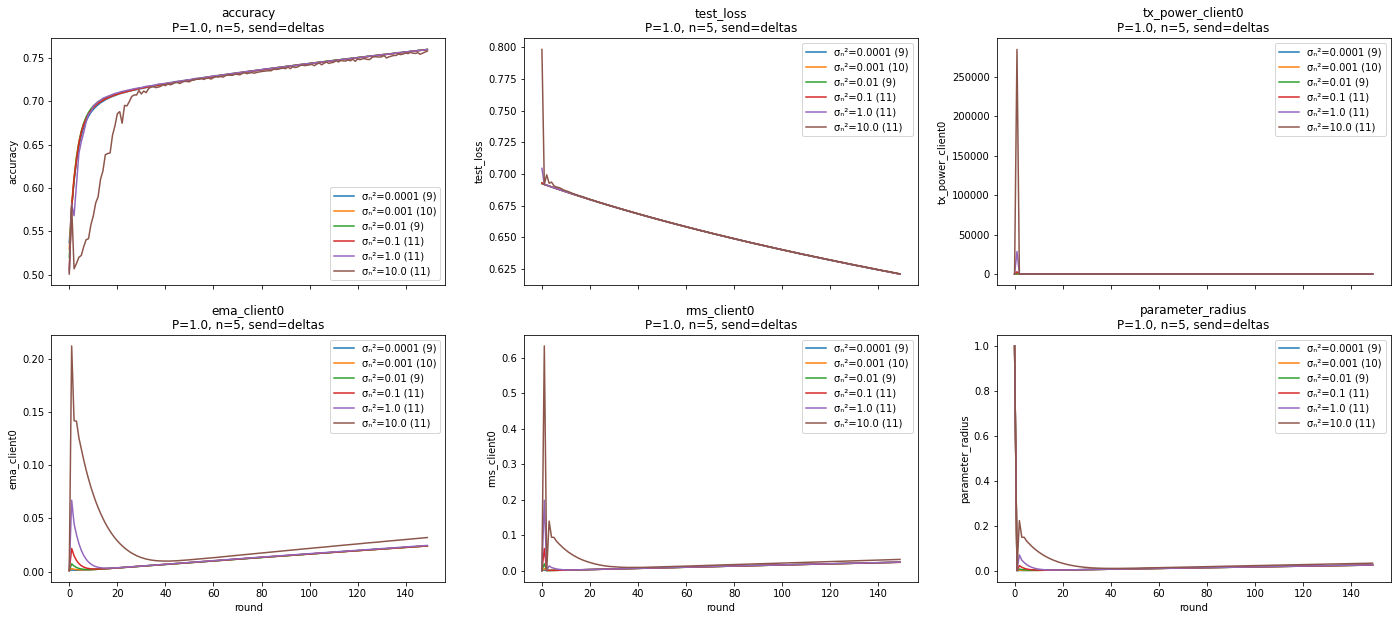

In [3]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'power_update_period': 1,
    'power_quantile': 0.9,
    'power_factor': 0.9,
    'data_per_client': 20000,
}
title_specs = {
    'power': 1.0,
    'clients': 5,
    'send': 'deltas',
}
series_specs = {
    'noise': [1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0],  # 100 is a disaster and obscures most of these plots for this setting
}
fields = ['accuracy', 'test_loss', 'tx_power_client0', 'ema_client0', 'rms_client0', 'parameter_radius']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

Check the variance of the accuracy charts:

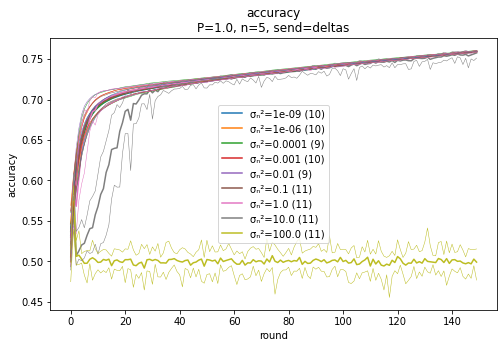

In [4]:
series_specs['noise'] = '__all__'
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

Does the power converge where it's meant to? That delta function gets in the way, zoom in:

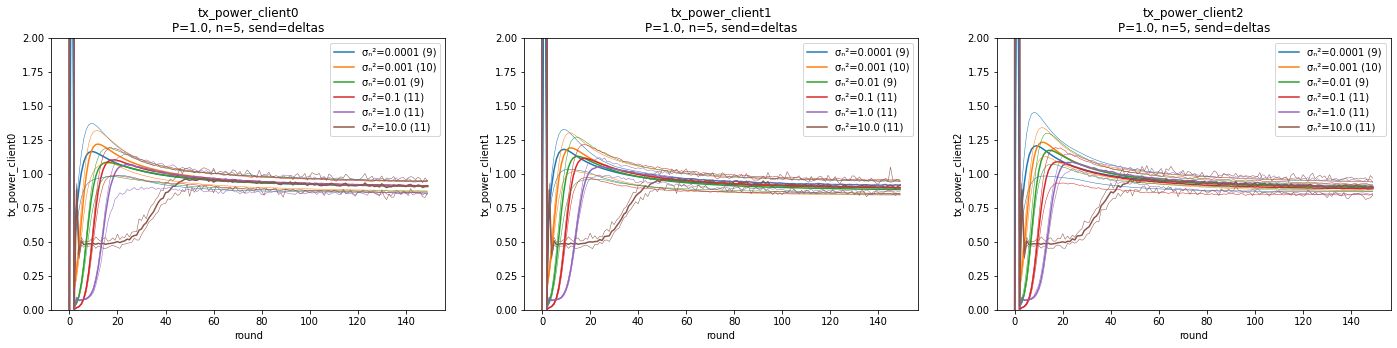

In [5]:
series_specs['noise'] = [1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0]
plot_averaged_training_charts(results_dir, ['tx_power_client0', 'tx_power_client1', 'tx_power_client2'], title_specs, fixed_specs, series_specs, plot_range=True)
for ax in plt.gcf().axes:
    ax.set_ylim((0, 2))

Check `send=params` charts:

(Note, we didn't run these for noise levels 0.0001, 0.001 or 0.01.)

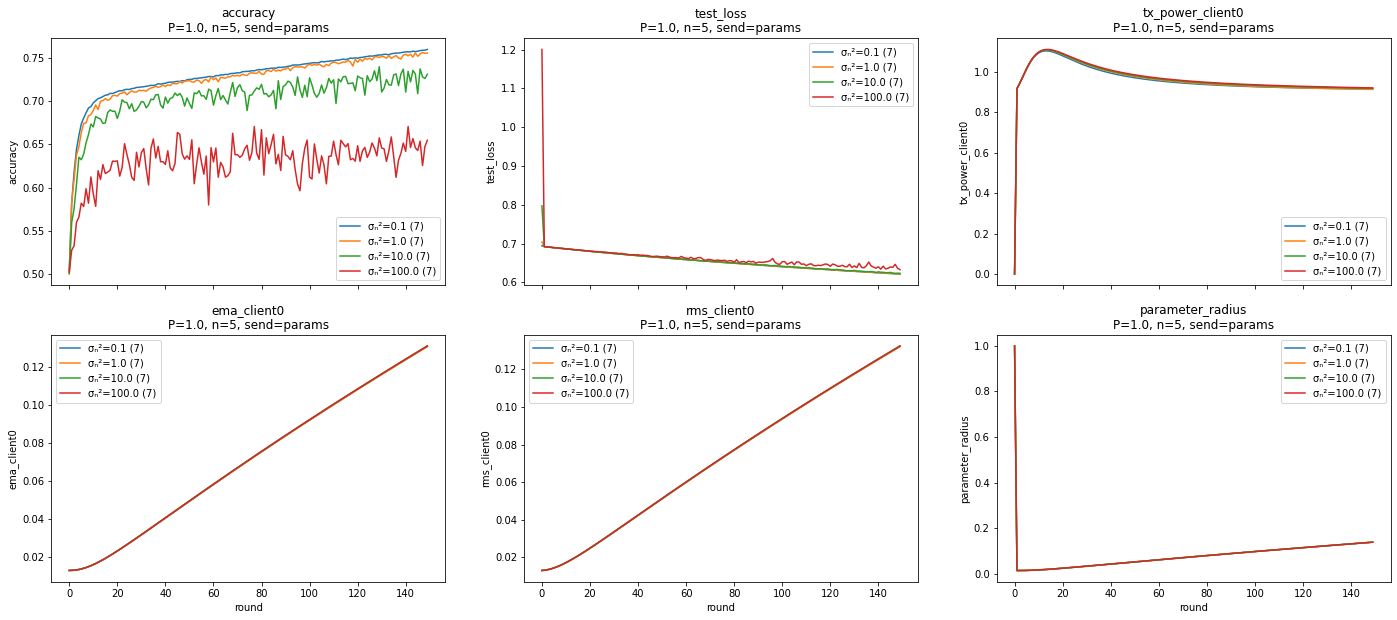

In [6]:
series_specs['noise'] = '__all__'
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

# Dynamic power, $n = 20$

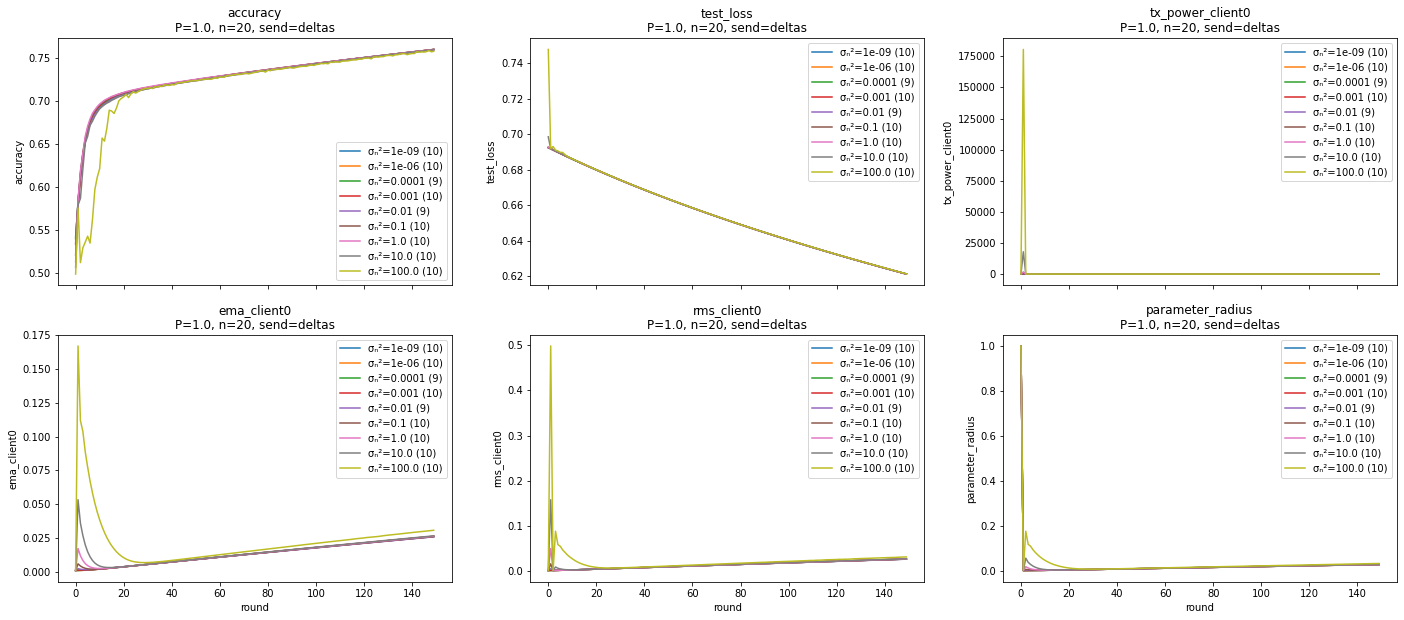

In [7]:
title_specs['clients'] = 20
title_specs['send'] = 'deltas'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

Check power:

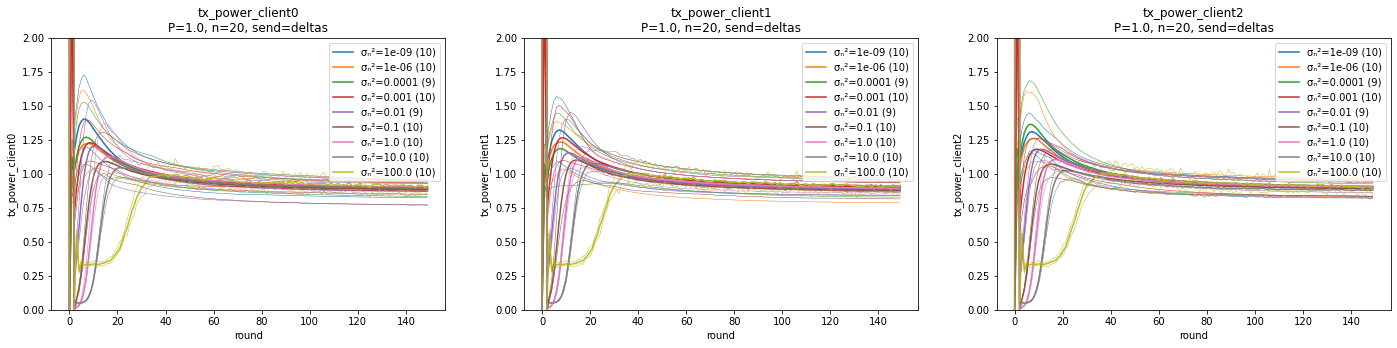

In [8]:
plot_averaged_training_charts(results_dir, ['tx_power_client0', 'tx_power_client1', 'tx_power_client2'], title_specs, fixed_specs, series_specs, plot_range=True)
for ax in plt.gcf().axes:
    ax.set_ylim((0, 2))

Check `send=params`:

(Note, we didn't run these for noise levels 0.0001, 0.001 or 0.01.)

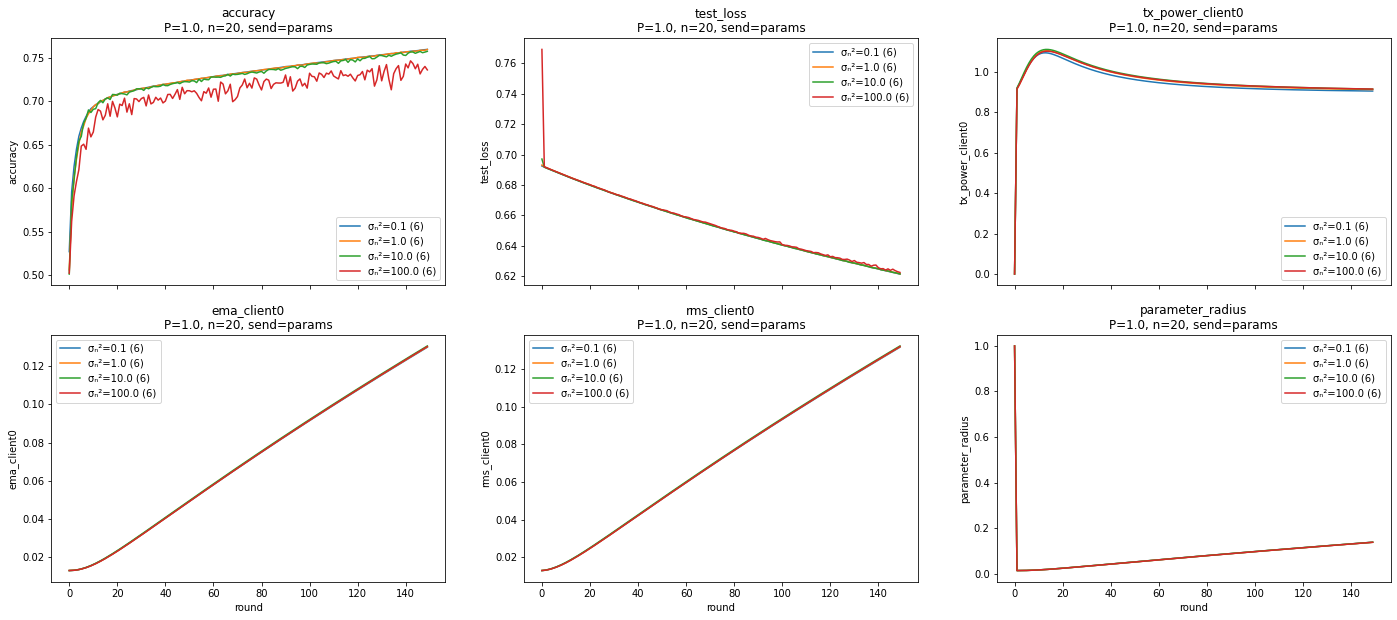

In [9]:
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

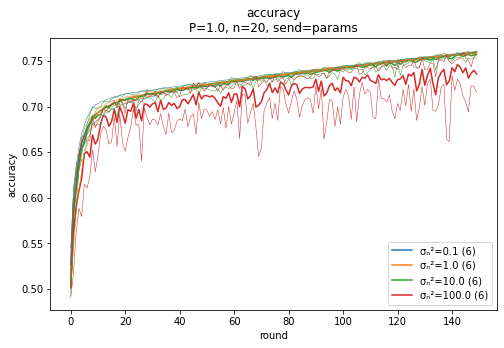

In [10]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

# Dynamic quantization range, $n = 5$

First, the "real" ones, using the `read-zero` option:

In [11]:
results_dir = [Path("results/20210722-dynquant/"), Path("results/20210723-lownoise-dynquant/"), Path("results/20210724-epsilon-dynquant")]
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **22 Jul 2021, 08:52:53** | 22 Jul 2021, 09:04:35 | 11 min 42 s |
| last to finish | 25 Jul 2021, 00:13:43 | **25 Jul 2021, 00:47:26** | 33 min 42 s |
| shortest | 24 Jul 2021, 15:13:27 | 24 Jul 2021, 15:22:47 | **9 min 20 s** |
| longest | 23 Jul 2021, 07:51:38 | 23 Jul 2021, 08:39:44 | **48 min 06 s** |


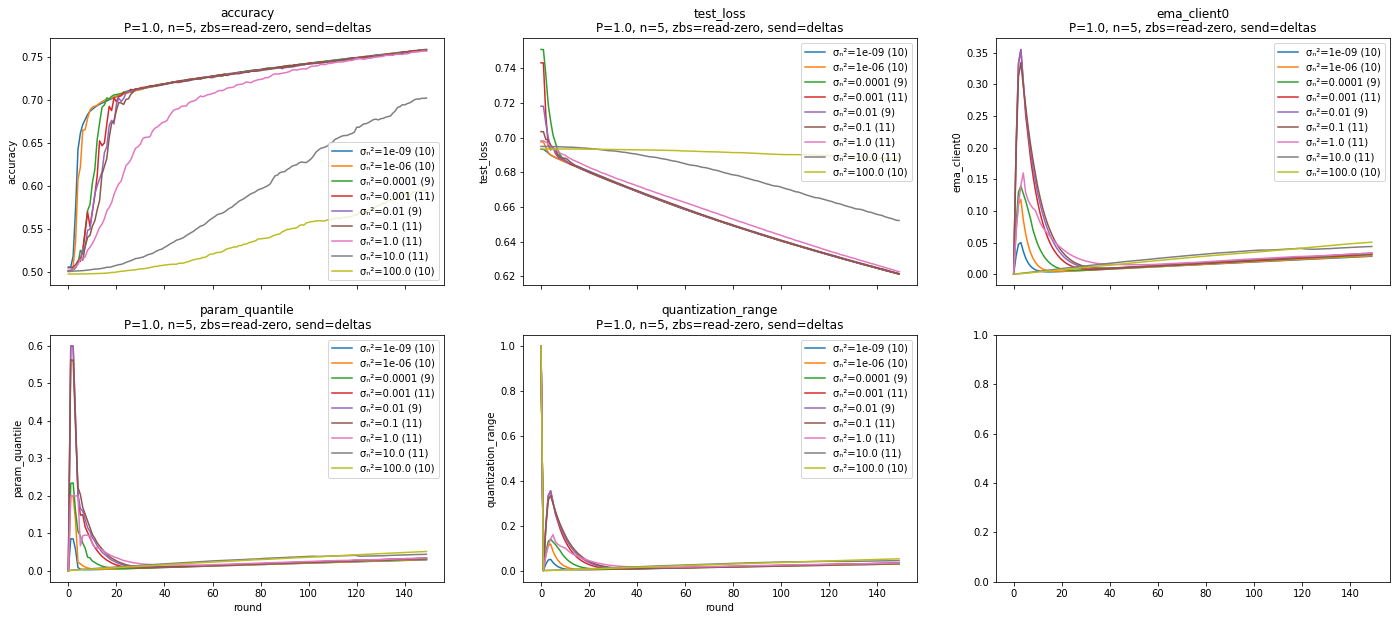

In [12]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'qrange_update_period': 1,
    'qrange_param_quantile': 0.9,
    'qrange_client_quantile': 0.9,
    'data_per_client': 20000,
    'channel_uses': None,
    'rounding_method': ['stochastic', '__missing__'],
}
title_specs = {
    'power': 1.0,
    'clients': 5,
    'zero_bits_strategy': 'read-zero',
    'send': 'deltas',
}
series_specs = {
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'ema_client0', 'param_quantile', 'quantization_range']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

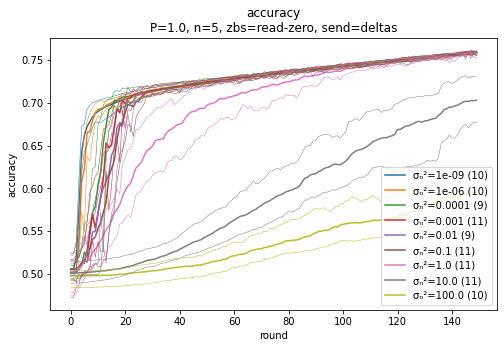

In [13]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

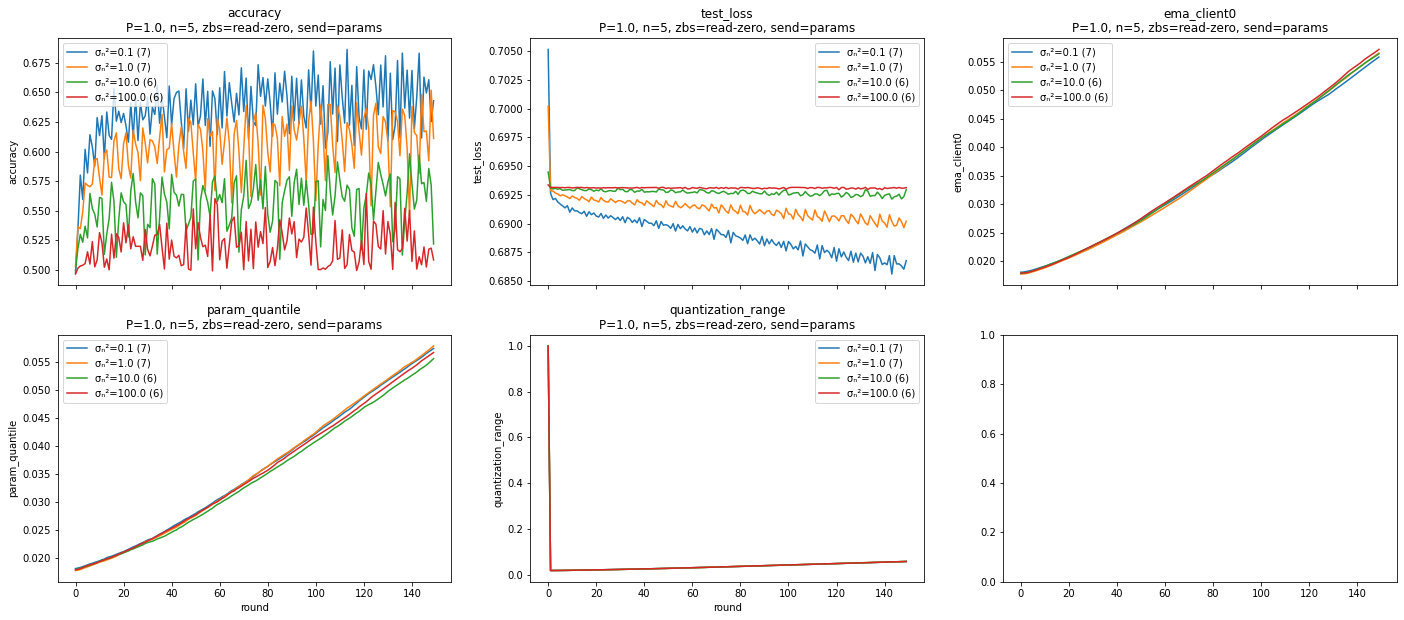

In [14]:
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

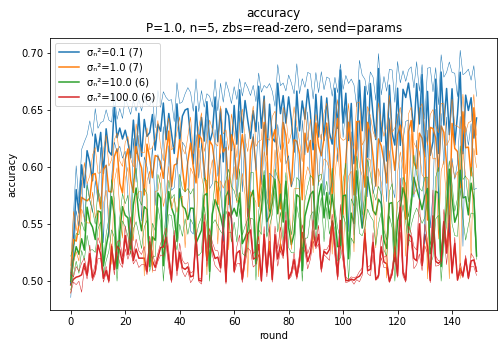

In [15]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

The `min-one` ones perform surprisingly well, but they also (by design) give the digital scheme an unrealistic advantage.

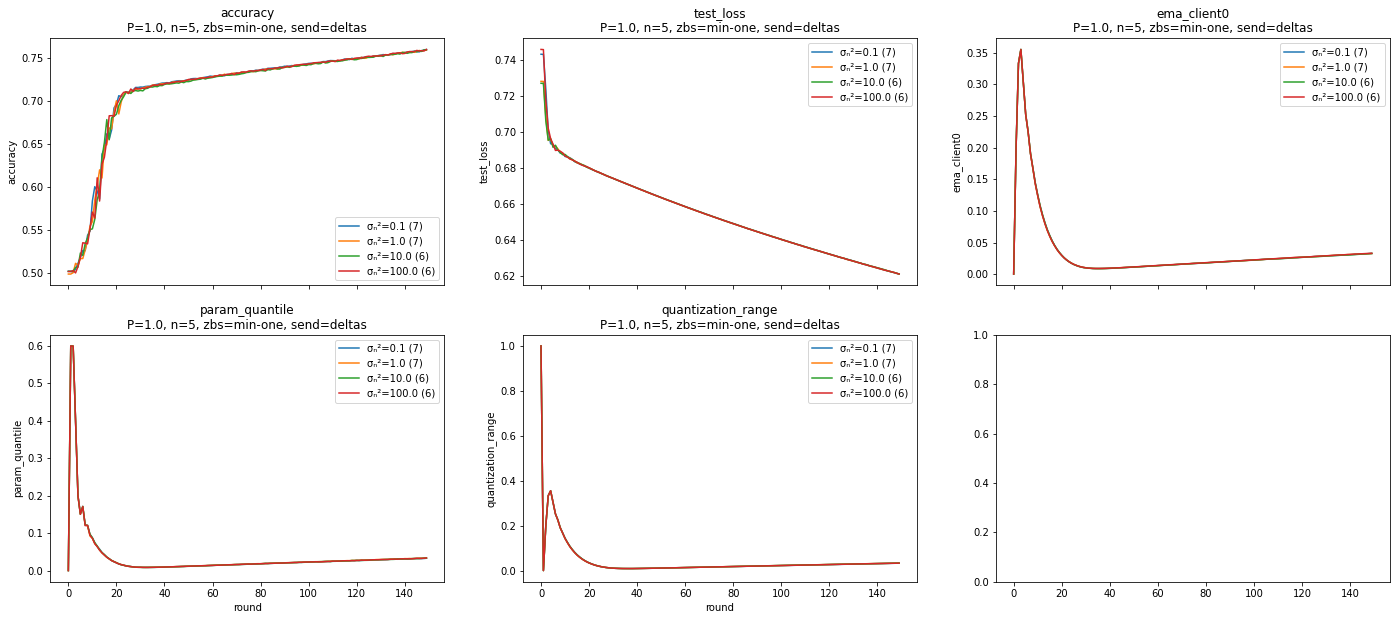

In [16]:
title_specs['zero_bits_strategy'] = 'min-one'
title_specs['send'] = 'deltas'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

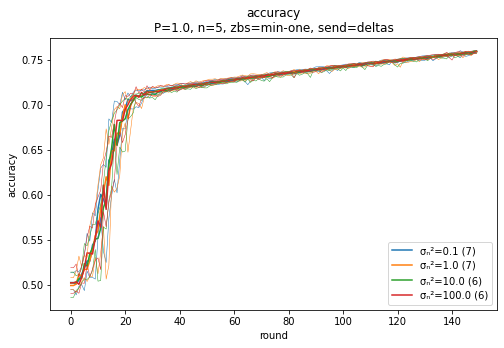

In [17]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

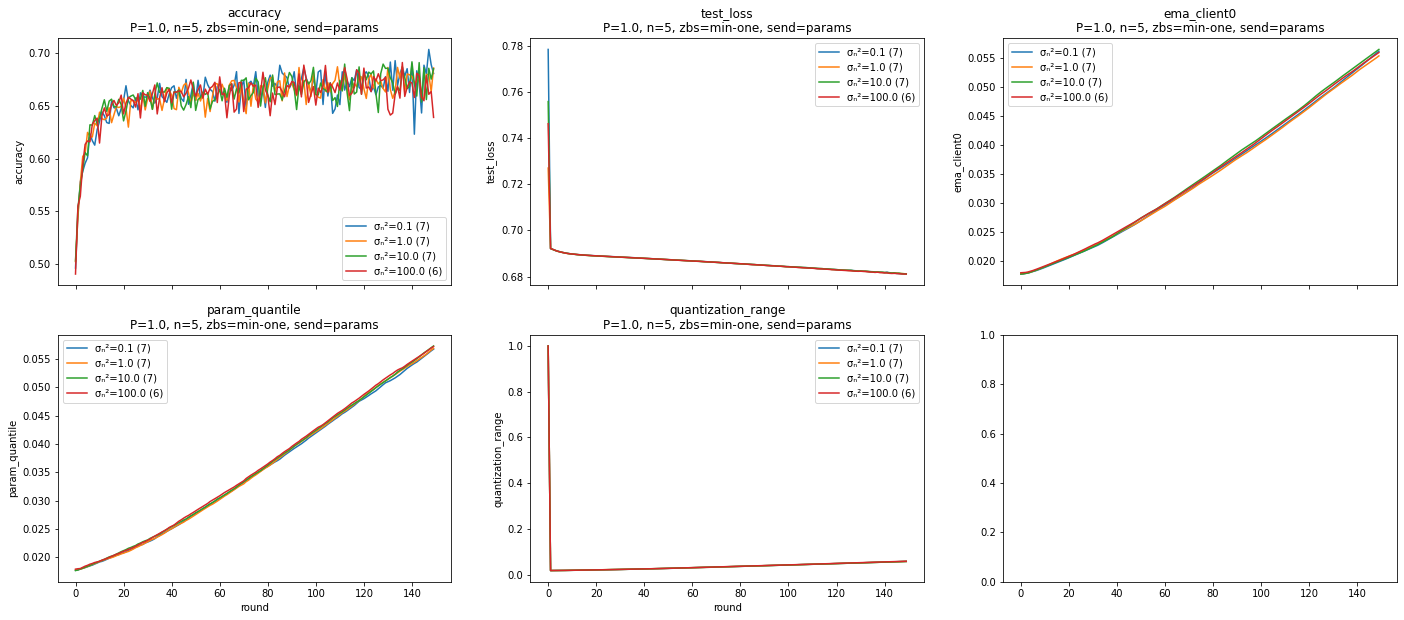

In [18]:
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

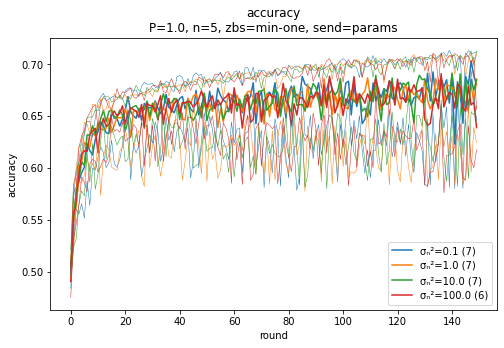

In [19]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

# Dynamic quantization range, $n = 20$

First, the "real" ones, using the `read-zero` option:

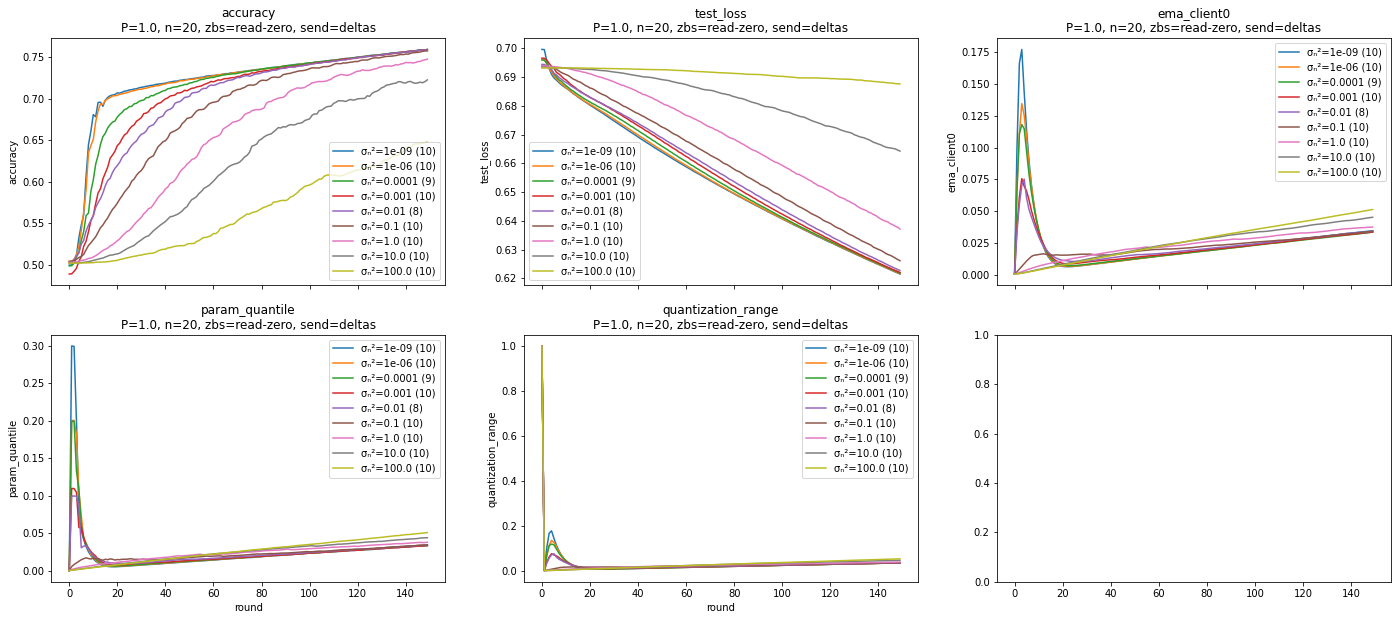

In [20]:
title_specs = {
    'power': 1.0,
    'clients': 20,
    'zero_bits_strategy': 'read-zero',
    'send': 'deltas',
}
data = plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

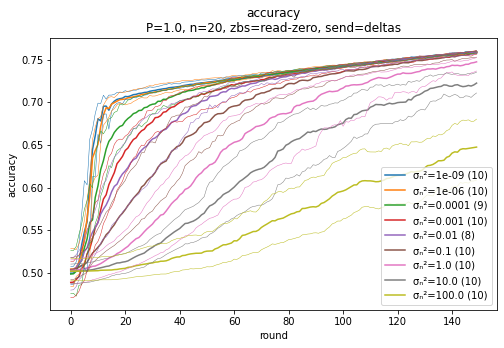

In [21]:
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs, plot_range=True)

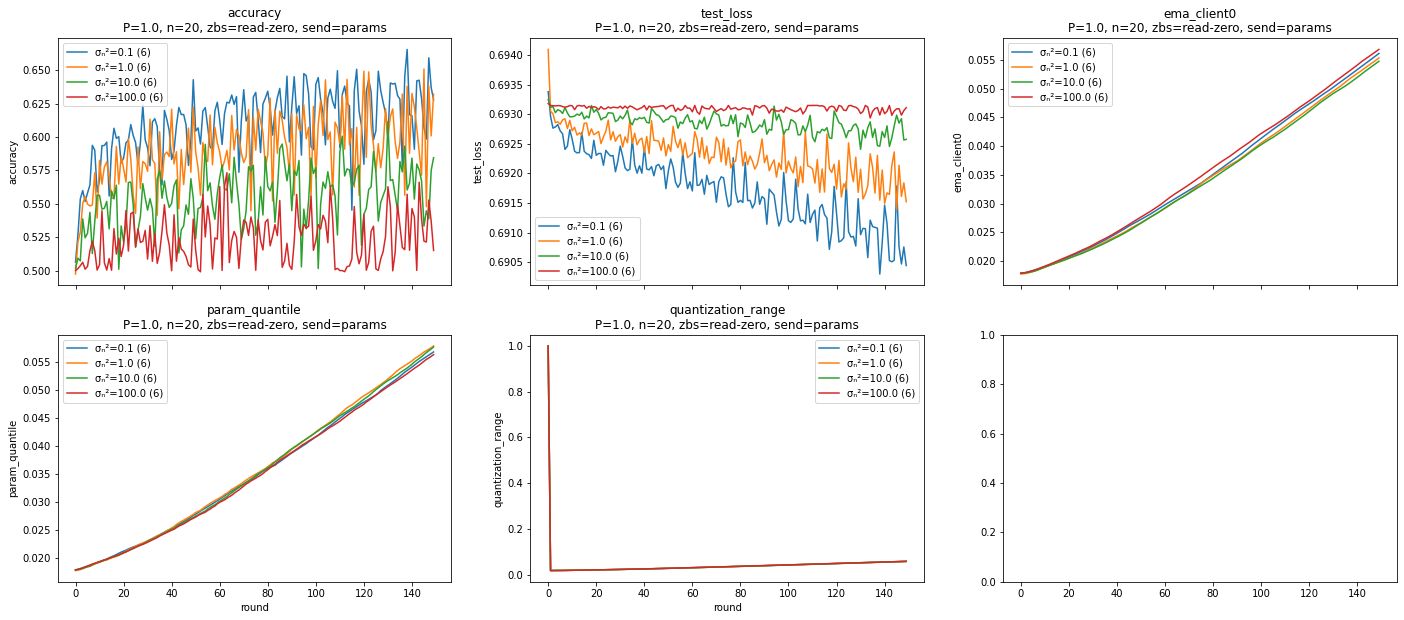

In [22]:
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

The `min-one` ones perform surprisingly well, but they also (by design) give the digital scheme an unrealistic advantage.

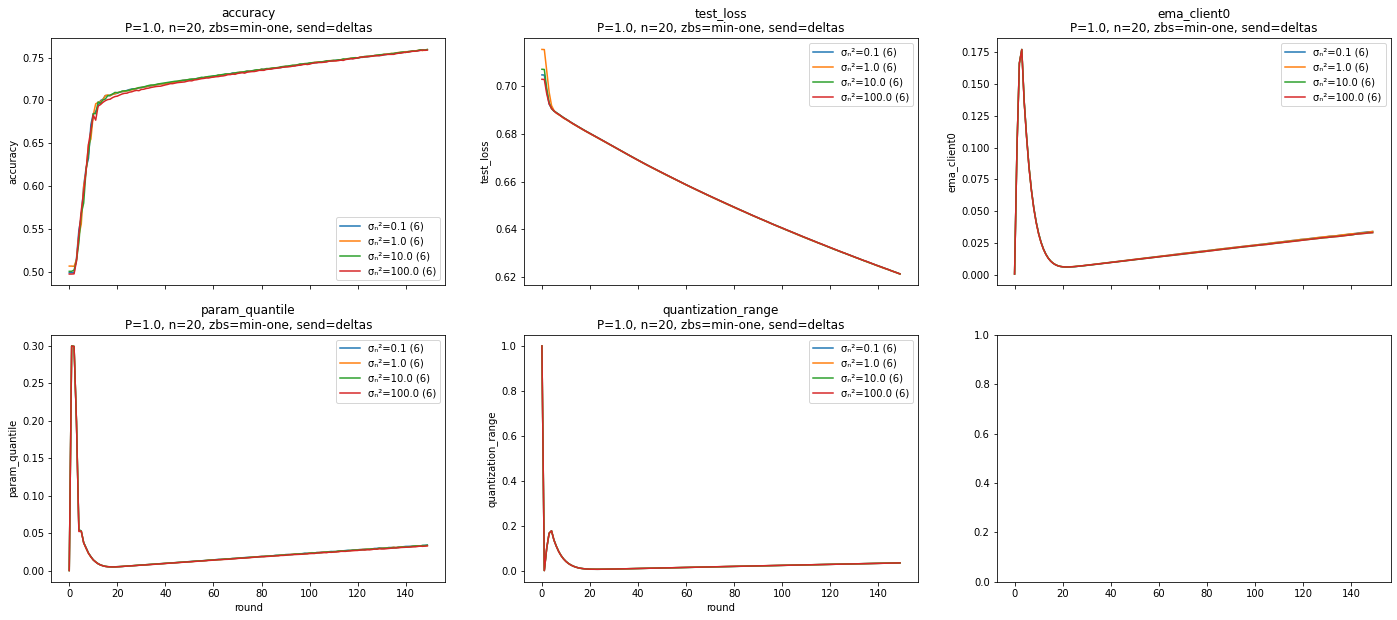

In [23]:
title_specs['zero_bits_strategy'] = 'min-one'
title_specs['send'] = 'deltas'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

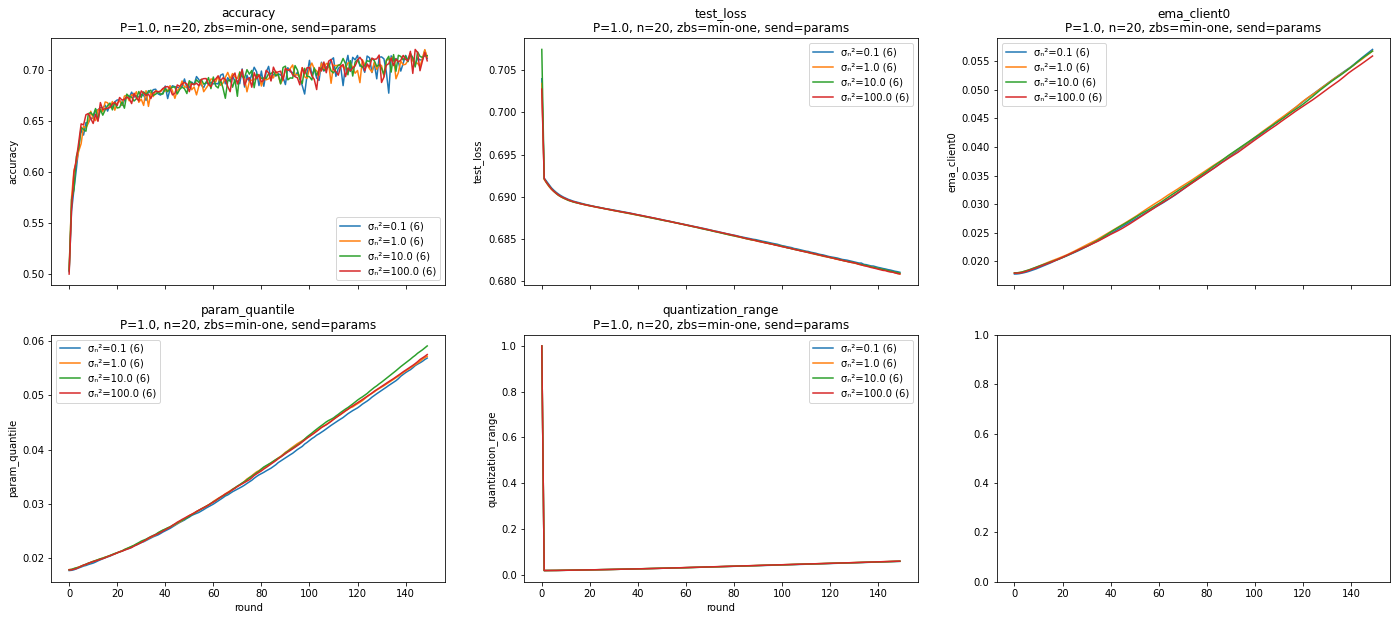

In [24]:
title_specs['send'] = 'params'
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

# Bits count

How many bits do we have in each of these settings?

In [25]:
# check in files

from numpy import log2
import pandas as pd
from plots_utils import all_subsubdirectories, get_args, get_eval

seen = []
reports = pd.DataFrame()
s = 2001  # number of channel uses

for directory in all_subsubdirectories(results_dir):
    args = get_args(directory)
    
    P = args['power']
    σₙ2 = args['noise']
    n = args['clients']
    if (P, σₙ2, n) in seen:
        continue
        
    try:
        evaluation = get_eval(directory)
    except FileNotFoundError:
        continue

    index = directory.name
    reports.loc[index, 'P'] = P
    reports.loc[index, 'σₙ²'] = σₙ2
    reports.loc[index, 'n'] = n

    reports.loc[index, 'bpcu eval'] = evaluation['bits_per_channel_use']
    reports.loc[index, 'bpr eval'] = evaluation['bits_per_round']

    seen.append((P, σₙ2, n))

reports['bpcu calc'] = log2(1 + reports['n'] * reports['P'] / reports['σₙ²']) / (2 * reports['n'])
reports['bpr calc'] = reports['bpcu calc'] * s
reports['bpcu diff'] = abs(reports['bpcu calc'] - reports['bpcu eval'])
reports['bpr diff'] = abs(reports['bpr calc'] - reports['bpr eval'])

reports.sort_index()

,P,σₙ²,n,bpcu eval,bpr eval,bpcu calc,bpr calc,bpcu diff,bpr diff
clients-20-noise-0.0001-iteration-1,1.0,1.000000e-04,20.0,0.440241,880.922626,0.440241,880.922626,0.000000e+00,0.000000e+00
clients-20-noise-0.001-iteration-6,1.0,1.000000e-03,20.0,0.357195,714.746420,0.357195,714.746420,0.000000e+00,0.000000e+00
clients-20-noise-0.01-iteration-3,1.0,1.000000e-02,20.0,0.274163,548.599435,0.274163,548.599435,0.000000e+00,0.000000e+00
clients-20-noise-0.1-iteration-4,1.0,1.000000e-01,20.0,0.191276,382.743861,0.191276,382.743861,2.775558e-17,5.684342e-14
clients-20-noise-1.0-iteration-3,1.0,1.000000e+00,20.0,0.109808,219.725679,0.109808,219.725679,0.000000e+00,0.000000e+00
clients-20-noise-10.0-iteration-5,1.0,1.000000e+01,20.0,0.039624,79.287749,0.039624,79.287749,0.000000e+00,0.000000e+00
clients-20-noise-100.0-iteration-1,1.0,1.000000e+02,20.0,0.006576,13.158296,0.006576,13.158296,0.000000e+00,0.000000e+00
clients-20-noise-1e-06-iteration-1,1.0,1.000000e-06,20.0,0.606337,1213.281174,0.606337,1213.281174,0.000000e+00,0.000000e+00
clients-20-noise-1e-09-iteration-5,1.0,1.000000e-09,20.0,0.855482,1711.819529,0.855482,1711.819529,0.000000e+00,0.000000e+00
clients-5-noise-0.0001-iteration-0,1.0,1.000000e-04,5.0,1.560967,3123.494833,1.560967,3123.494833,0.000000e+00,0.000000e+00


# Comparison plots

I think the `send=params, zbs=read-zero` plots aren't very useful. They transmit zero for a bunch of parameters where there's not enough bits to go around. For `send=deltas` this is okay, because the model just doesn't change. But for `send=params` this is saying, "if I don't here about the model, assume it's zero", which is nonsense. There are modifications to work around this (like, the server could notice and not update the model for those parameters), but they still seem inferior to `send=deltas`.

In [26]:
analog_path = [Path("results/20210722-dynpower-2/"), Path("results/20210723-lownoise-dynpower"), Path("results/20210724-epsilon-dynpower")]
digital_path = [Path("results/20210722-dynquant/"), Path("results/20210723-lownoise-dynquant"), Path("results/20210724-epsilon-dynquant")]

def get_comparison_specs(clients, send, zero_bits_strategy, noise):

    common_fixed_specs = {
        'rounds': 150,
        'batch_size': 64,
        'lr_client': 0.01,
        'momentum_client': 0.0,
        'epochs': 1,
        'dataset': 'epsilon',
        'ema_coefficient': 1 / 3,
        'data_per_client': 20000,
    }

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'power_update_period': 1,
        'power_quantile': 0.9,
        'power_factor': 0.9,
    })
    title_specs = {
        'power': 1.0,
        'clients': clients,
        'send': send,
    }
    series_specs = {
        'noise': noise,
    }

    all_analog_specs = title_specs, fixed_specs, series_specs

    fixed_specs = common_fixed_specs.copy()
    fixed_specs.update({
        'qrange_update_period': 1,
        'qrange_param_quantile': 0.9,
        'qrange_client_quantile': 0.9,
        'channel_uses': None,
        'rounding_method': ['stochastic', '__missing__'],
    })
    title_specs = title_specs.copy()
    title_specs.update({
        'zero_bits_strategy': zero_bits_strategy,
    })

    all_digital_specs = title_specs, fixed_specs, series_specs
    
    return all_analog_specs, all_digital_specs

## High noise plots

Too many lines to have analog and digital on the same plot for all the noise levels we tried. Just do the four highest noise levels first:

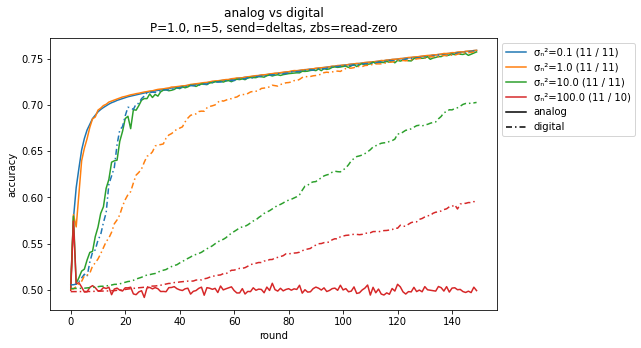

In [27]:
all_specs = get_comparison_specs(5, 'deltas', 'read-zero', [0.1, 1.0, 10.0, 100.0])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

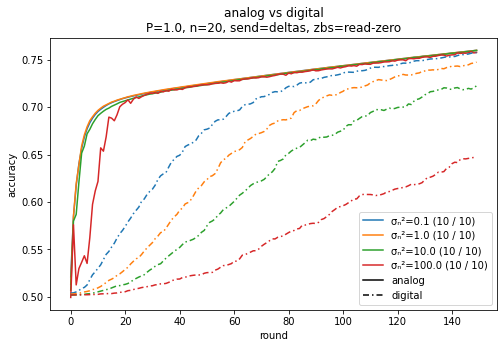

In [28]:
all_specs = get_comparison_specs(20, 'deltas', 'read-zero', [0.1, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

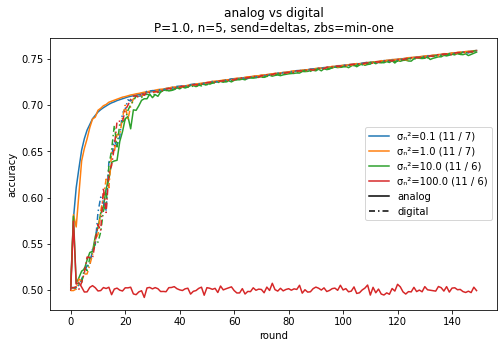

In [29]:
all_specs = get_comparison_specs(5, 'deltas', 'min-one', [0.1, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

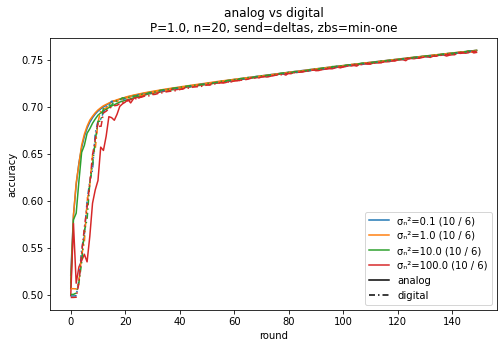

In [30]:
all_specs = get_comparison_specs(20, 'deltas', 'min-one', [0.1, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

I'm not totally convinced the `send=params,zbs=min-one` plots are useful either. They're not as nonsensical as `send=params,zbs=read-zero`, but saying model parameters can only take on one of two values is still a weird concept. Again, there are potential workarounds we haven't implemented (_e.g._ the server could keep track of the average), but they seem less clean than `send=deltas`. Here they are nonetheless:

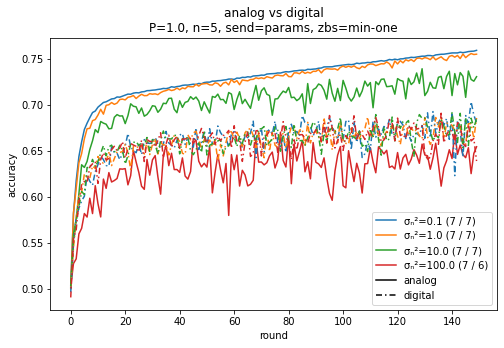

In [31]:
all_specs = get_comparison_specs(5, 'params', 'min-one', [0.1, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

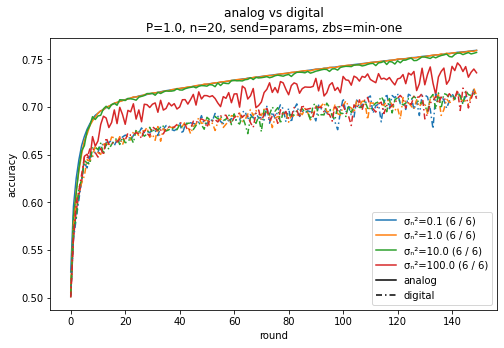

In [32]:
all_specs = get_comparison_specs(20, 'params', 'min-one', [0.1, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

## Low noise plots

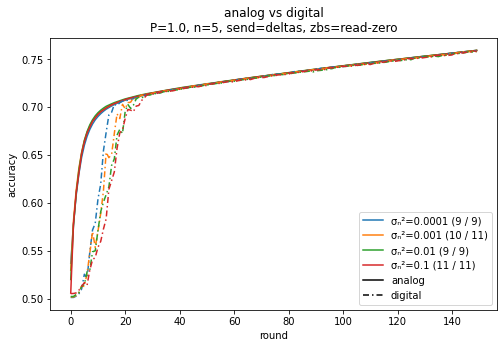

In [33]:
all_specs = get_comparison_specs(5, 'deltas', 'read-zero', [0.0001, 0.001, 0.01, 0.1])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

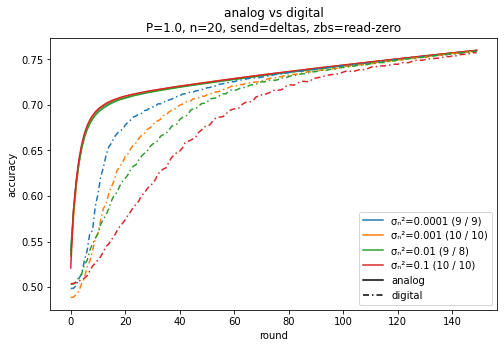

In [34]:
all_specs = get_comparison_specs(20, 'deltas', 'read-zero', [0.0001, 0.001, 0.01, 0.1])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

# Cherry-pick noise levels for clarity

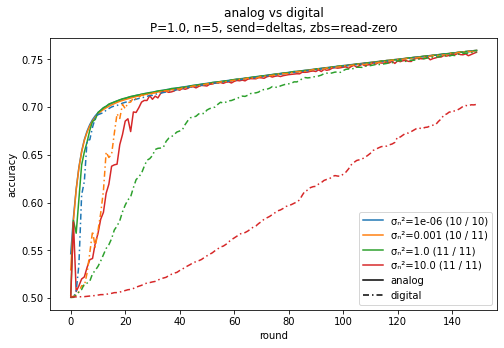

In [35]:
all_specs = get_comparison_specs(5, 'deltas', 'read-zero', [1e-6, 1e-3, 1, 10])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)

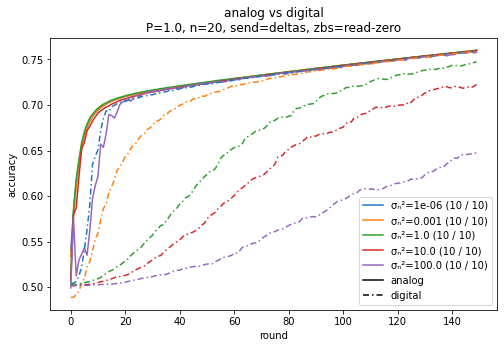

In [36]:
all_specs = get_comparison_specs(20, 'deltas', 'read-zero', [1e-6, 1e-3, 1, 10, 100])
plot_comparison('accuracy', analog_path, digital_path, *all_specs)